## Import necessary modules
Run this cell before running any other cells

In [ ]:
from uuid import uuid4
uuid4()

In [ ]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

# Printing and Logging
## Printing
You can use the **print()** function in Python to print messages to the screen. <br>
The message can be a string, or any other object, the object will be converted into a string before it is written to the screen. <br>

## Logging
You could use the logging module that is setup in *utils.py*. <br>
It prints to both your screen (standard output) as well as to log files (*ble.log*) in the *logs* directory. <br>
This is the recommended way to output messages, since the log files can help with debugging. <br>
The logging module also provides different log levels as shown below, each formatted with a different color for increased visibility. <br>

__**NOTE**__: You may notice that the DEBUG message is not printed to the screen but is printed in the log file. This is because the logging level for the screen is set to INFO and for the file is set to DEBUG. You can change the default log levels in *utils.py* (**STREAM_LOG_LEVEL** and **FILE_LOG_LEVEL**). 

## Formatting output
To format your strings, you may use %-formatting, str.format() or f-strings. <br>
The most "pythonic" way would be to use f-strings. [Here](https://realpython.com/python-f-strings/) is a good tutorial on f-strings. <br>

In [ ]:
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")

<hr>

# BLE
## ArtemisBLEController
The class **ArtemisBLEController** (defined in *ble.py*) provides member functions to handle various BLE operations to send and receive data to/from the Artemis board, provided the accompanying Arduino sketch is running on the Artemis board. <br>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Functions</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">reload_config()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Reload changes made in <em>connection.yaml.</em></span></th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">connect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Connect to the Artemis board, whose MAC address is specified in <em>connection.yaml</em>.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">disconnect()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Disconnect from the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">is_connected()</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Return a boolean indicating whether your controller is connected to the Artemis board or not.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">send_command(cmd_type, data)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Send the command <strong>cmd_type</strong> (integer) with <strong>data</strong> (string) to the Artemis board.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">receive_float(uuid) <br> receive_string(uuid) <br> receive_int(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Read the GATT characteristic (specified by its <strong>uuid</strong>) of type float, string or int. <br> The type of the GATT
            characteristic is determined by the classes BLEFloatCharacteristic, BLECStringCharacteristic or
            BLEIntCharacteristic in the Arduino sketch.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">start_notify(uuid, notification_handler)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Activate notifications on the GATT characteristic (specified by its <strong>uuid</strong>). <br> <strong>notification_handler</strong> is a
            function callback which must accept two inputs; the first will be a uuid string object and the second will
            be the bytearray of the characteristic value.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">bytearray_to_float(byte_array) <br> bytearray_to_string(byte_array) <br> bytearray_to_int(byte_array)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Convert the <strong>bytearray</strong> to float, string or int, respectively. <br> You may use these functions inside your
            notification callback function.</span></th>
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">stop_notify(uuid)</span></th>
        <th style="text-align: left"><span style="font-weight: normal">Stop notifications on the GATT characteristic (specified by its <strong>uuid</strong>).</span></th>
    </tr>
</table>

<table align="left">
     <tr>
        <th style="text-align: left; font-size: medium">Member Variables</th>
        <th style="text-align: left; font-size: medium">Description</th style="text-align: left">
    </tr>
    <tr>
        <th style="text-align: left"><span style="color:rgb(201,152,4);font-family:monospace">uuid</span></th>
        <th style="text-align: left"><span style="font-weight: normal">A dictionary that stores the UUIDs of the various characteristics specified in <em>connection.yaml</em>.</span></th>
    </tr>
</table>

## Configuration
- The MAC address, Service UUID and GATT characteristic UUIDs are defined in the file: *connection.yaml*.
- They should match the UUIDs used in the Arduino sketch.
- The artemis board running the base code should display its MAC address in the serial monitor.
- Update the **artemis_address** in *connection.yaml*, accordingly.
- Make sure to call **ble.reload_config()** or **get_ble_controller()** (which internally calls **reload_config()**) after making any changes to your configuration file.

<hr>

In the below cell, we create an **ArtemisBLEController** object using **get_ble_controller()** (defined in *ble.py*), which creates and/or returns a single instance of **ArtemisBLEController**. <br>
<span style="color:rgb(240,50,50)"> __NOTE__: Do not use the class directly to instantiate an object. </span><br>

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

## Receive data from the Artemis board

The cell below shows examples of reading different types (as defined in the Arduino sketch) of GATT characteristics.

In [ ]:
# Read a float GATT Charactersistic
f = ble.receive_float(ble.uuid['RX_FLOAT'])
print(f)

In [ ]:
# Read a string GATT Charactersistic
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

## Send a command to the Artemis board
Send the PING command and read the reply string from the string characteristic RX_STRING. <br>
__NOTE__: The **send_command()** essentially sends a string data to the GATT characteristic (TX_CMD_STRING). The GATT characteristic in the Arduino sketch is of type BLECStringCharacteristic.

In [ ]:
ble.send_command(CMD.PING, "")

In [ ]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

The cell below shows an example of the SEND_TWO_INTS command. <br> The two values in the **data** are separated by a delimiter "|". <br>
Refer Lab 2 documentation for more information on the command protocol.

In [ ]:
ble.send_command(CMD.SEND_TWO_INTS, "2|-6")

The Artemis board should print the two integers to the serial monitor in the ArduinoIDE. 

## Disconnect

In [ ]:
# Disconnect
ble.disconnect()

# Lab

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

## Connect

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

## Task 1

In [ ]:
ble.send_command(CMD.ECHO, "QUACK!")

In [ ]:
echo = ble.receive_string(ble.uuid['RX_STRING'])
print(echo)

## Task 2

In [ ]:
ble.send_command(CMD.GET_TIME_MILLIS, "")

In [ ]:
millis = ble.receive_string(ble.uuid['RX_STRING'])
print(millis)

## Task 3

In [ ]:
time = 0

def str_notify_handler(uuid, byte_array):
    global time
    byte_array = ble.bytearray_to_string(byte_array)
    time = byte_array[2:]
    time = int(time)
    print("Time:", time, "ms")

In [ ]:
ble.start_notify(ble.uuid['RX_STRING'], str_notify_handler)

In [ ]:
ble.stop_notify(ble.uuid['RX_STRING'])

## Task 4

In [ ]:
times = []
temps = []

def str_notify_handler(uuid, byte_array):
    lst = []
    global times
    global temps
    byte_array = ble.bytearray_to_string(byte_array)

    while(True):
        try:
            index = byte_array.index('|')
            lst.append(byte_array[:index])
            byte_array = byte_array[index+1:]
        except:
            lst.append(byte_array)
            break

    for i in range(len(lst)):
        if i%2 == 0:
            times.append(lst[i][2:])
        else:
            temps.append(lst[i][2:])

    print("Time(ms)    ", "Temperature(C)")
    for i in range(len(times)):
        print(times[i], "      ", temps[i])

In [ ]:
ble.start_notify(ble.uuid['RX_STRING'], str_notify_handler)

In [ ]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [ ]:
ble.send_command(CMD.GET_TEMP_5s, "")

## Task 5

In [ ]:
lst = []
def str_notify_handler(uuid, byte_array):
    global times
    global temps
    global lst
    data = ble.bytearray_to_string(byte_array)
    
    while(True):
        try:
            index = data.index('|')
            lst.append(data[:index])
            data = data[index+1:]
        except:
            #lst.append(data)
            break

    #print("5s of temperature readings stored in temps list.")

In [ ]:
ble.start_notify(ble.uuid['RX_STRING'], str_notify_handler)

In [ ]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [ ]:
ble.send_command(CMD.GET_TEMP_5s_RAPID, "")

In [ ]:
times = []
temps = []

for i in range(len(lst)):
    if i%2 == 0:
        times.append(lst[i][2:])
    else:
        temps.append(lst[i][2:])

print("Time(ms)    ", "Temperature(C)")
for i in range(len(times)):
    print(times[i], "      ", temps[i])
# print(lst)
# print(times)
# print(temps)
print("Total # of temperature measurements taken:", len(temps))

## Lab 3 Task 9

In [ ]:
import numpy as np
lst = []
means = np.zeros(15)
stdevs = np.zeros(15)
def str_notify_handler(uuid, byte_array):
    global lst
    data = ble.bytearray_to_string(byte_array)
    print(data)
    
    while(True):
        try:
            index = data.index('|')
            lst.append(data[:index])
            data = data[index+1:]
        except:
            break

In [ ]:
ble.start_notify(ble.uuid['RX_STRING'], str_notify_handler)

In [ ]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [ ]:
ble.send_command(CMD.GET_DIST, "5000")

In [ ]:
import statistics as stat
times = []
dist1 = []
dist2 = []

counter = 0
for i in range(len(lst)):
    if counter == 0:
        times.append(int(lst[i][2:]))
    elif counter == 1:
        dist1.append(int(lst[i][3:]))
    elif counter == 2:
        dist2.append(int(lst[i][3:]))
    counter += 1
    counter = counter % 3

print("Time(ms)    ", "Distance 1(cm)    ", "Distance 2(cm)    ")
for i in range(len(times)):
    print(times[i], "      ", dist1[i], "              ", dist2[i])

print("Average distances: ", stat.mean(dist1), "              ", stat.mean(dist2))
print("Standard deviations: ", stat.stdev(dist1), "              ", stat.stdev(dist2))

index = 1 # CHANGE THIS for each distance
means[index-1] = stat.mean(dist2)
stdevs[index-1] = stat.stdev(dist2)
print(means)
print(stdevs)
lst = []

In [ ]:
savemeans = means
savestdevs = stdevs

In [ ]:
real_distances = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
plt.plot(real_distances, means, label = 'Mean sensor reading')
plt.plot(real_distances, stdevs, label = 'Standard deviation')
plt.xlabel('Actual Distance(cm)')
plt.ylabel('Sensor Distance(cm)')
plt.legend()
plt.show()

In [ ]:
pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
plt.plot(times, dist1)
plt.plot(times, dist2)
plt.xlabel('Time(ms)')
plt.ylabel('Distance(cm)')
plt.show()

### Imports and connect to BLE again for convenience

In [ ]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

In [ ]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

## Lab 4

### IMU only

In [ ]:
import numpy as np
lst = []
def str_notify_handler(uuid, byte_array):
    global lst
    data = ble.bytearray_to_string(byte_array)
    print(data)
    
    while(True):
        try:
            index = data.index('|')
            lst.append(data[:index])
            data = data[index+1:]
        except:
            break

In [ ]:
ble.start_notify(ble.uuid['RX_STRING'], str_notify_handler)

In [ ]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [ ]:
ble.send_command(CMD.GET_IMU, "5000")

In [ ]:
import statistics as stat
times = []
pitch = []
roll = []
yaw = []

counter = 0
for i in range(len(lst)):
    if counter == 0:
        times.append(float(lst[i][2:]))
    elif counter == 1:
        pitch.append(float(lst[i][2:]))
    elif counter == 2:
        roll.append(float(lst[i][2:]))
    elif counter == 3:
        yaw.append(float(lst[i][2:]))
    counter += 1
    counter = counter % 4

print("Time(ms)      ", "Pitch          ", "Roll            ", "Yaw      ")
for i in range(len(times)):
    print(times[i], "      ", pitch[i], "        ", roll[i], "        ", yaw[i])

### TOF & IMU

In [ ]:
import numpy as np
tof = []
imu = []
def str_notify_handler(uuid, byte_array):
    global tof
    global imu
    data = ble.bytearray_to_string(byte_array)
    print(data)
    
    if (int(data[0]) == 1): #TOF data
        while(True):
            try:
                data = data[1:]
                index = data.index('|')
                tof.append(data[:index])
                data = data[index+1:]
            except:
                break
    elif (int(data[0]) == 2): #IMU data
        while(True):
            try:
                data = data[1:]
                index = data.index('|')
                imu.append(data[:index])
                data = data[index+1:]
            except:
                break
    else:
        print("Data is not classified as TOF or IMU")

In [ ]:
ble.start_notify(ble.uuid['RX_STRING'], str_notify_handler)

In [ ]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [ ]:
ble.send_command(CMD.GET_TOF_IMU, "5000")

In [ ]:
print(imu)

In [ ]:
import statistics as stat
times = []
pitch = []
roll = []
yaw = []

counter = 0
for i in range(len(imu)):
    if counter == 0:
        times.append(float(imu[i][2:]))
    elif counter == 1:
        pitch.append(float(imu[i][1:]))
    elif counter == 2:
        roll.append(float(imu[i][1:]))
    elif counter == 3:
        yaw.append(float(imu[i]))
    counter += 1
    counter = counter % 4

print("Time(ms)      ", "Pitch          ", "Roll            ", "Yaw      ")
for i in range(len(times)):
    print(times[i], "      ", pitch[i], "        ", roll[i], "        ", yaw[i])

In [ ]:
print(tof)

In [ ]:
import statistics as stat
dist_times = []
dist1 = []
dist2 = []

counter = 0
for i in range(len(tof)):
    if counter == 0:
        dist_times.append(int(tof[i][2:]))
    elif counter == 1:
        dist1.append(int(tof[i][2:]))
    elif counter == 2:
        dist2.append(int(tof[i][2:]))
    counter += 1
    counter = counter % 3

print("Time(ms)    ", "Distance 1(cm)    ", "Distance 2(cm)    ")
for i in range(len(dist_times)):
    print(dist_times[i], "      ", dist1[i], "              ", dist2[i])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(dist1)
plt.plot(dist2)
plt.xlabel('Time')
plt.ylabel('Distance(cm)')
plt.show()

In [ ]:
plt.plot(pitch, label = 'pitch')
plt.plot(roll, label = 'roll')
plt.xlabel('Time')
plt.legend()
plt.show()

## Lab 6 - Motors

### Imports and connect to BLE again for convenience

In [ ]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

In [547]:
# Get ArtemisBLEController object
ble = get_ble_controller()        

# Connect to the Artemis Device
ble.connect()

2023-04-21 16:18:32,606 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:83:24:6a:9a:3c
2023-04-21 16:18:35,751 | INFO     |: Connected to c0:83:24:6a:9a:3c


In [548]:
ble.send_command(CMD.PID, "")

tof_times = []
tof_data = []
speed_data = []
imu_data = []
imu_times = []
flag = 0

def str_notify_handler(uuid, byte_array):
    global lst
    global flag
    # print(byte_array)
    data = ble.bytearray_to_string(byte_array)
    print(data)
    
    # if(data[0] == '|'):
    #     flag = 1
    #     return
    if(flag == 0):
        tof_times.append(int(data[1 : data.index(',')]))
        data = data[data.index(',')+1:]
        tof_data.append(int(data[:data.index(',')]))
        data = data[data.index(',')+1:]
        imu_data.append(int(data[:-1]))
    # else:
    #     imu_times.append(int(data[1 : data.index(',')]))
    #     data = data[data.index(',')+1:]
    #     imu_data.append(int(data[:-1]))
    
ble.start_notify(ble.uuid['RX_STRING'], str_notify_handler)

In [549]:
ble.send_command(CMD.SEND_DATA, "")

(16486,1240,0)
(16498,1237,-4)
(16689,1243,-4)
(16871,1234,-4)
(17058,1237,-4)
(17244,1229,-4)
(17433,1246,-4)
(17616,1231,-4)
(17801,1236,-4)
(17987,1231,-4)
(18175,1238,-4)
(18268,1228,-4)
(18458,1245,-4)
(18638,1228,-4)
(18828,1234,-4)
(19015,1240,-4)
(19200,1232,-4)
(19384,1229,-3)
(19569,1240,-3)
(19764,1229,-4)
(19947,1233,-3)
(20137,1233,-4)
(20323,1237,-4)
(20500,1234,-4)
(20686,1237,-3)
(20793,1241,-3)
(20965,1238,-3)
(21154,1226,-3)
(21248,1229,-3)
(21438,1225,-3)
(21630,1231,-3)
(21814,1236,-3)
(22001,1233,-3)
(22178,1237,-3)
(22369,1236,-3)
(22453,1224,-3)
(22655,1230,-3)
(22832,1235,-3)
(23022,1243,-3)
(23198,1228,-2)
(23385,1231,-2)
(23572,1231,-2)
(23756,1234,-2)
(23949,1223,-2)
(24129,1237,-2)
(24236,1232,-2)
(24418,1231,-2)
(24598,1238,-1)
(24790,1237,-1)
(24975,1225,-1)
(25157,1234,-1)
(25349,1219,0)
(25530,1229,0)
(25721,1235,0)
(25899,1232,0)
(26096,1236,0)
(26277,1232,1)
(26466,1223,1)
(26645,1239,2)
(26833,1228,3)
(27019,1227,3)
(27117,1226,3)
(27205,1240,4)
(2729

In [550]:
# Disconnect
ble.disconnect()

2023-04-21 16:19:35,818 | INFO     |: Disconnected from 3E8FB54A-DE75-5568-901D-E91E2BD0E736


In [ ]:
# Possible strings for SEND_PWM:

# F + pwm, B + pwm, R + pwm, L + pwm, S000 (pwm must be 3 digits)
ble.send_command(CMD.SEND_PWM, "F080")

In [ ]:
ble.send_command(CMD.SEND_PWM, "S000")

In [ ]:
msg = ble.receive_string(ble.uuid['RX_STRING'])
print(msg)

In [551]:
save_times = tof_times
save_tof = tof_data
save_imu = imu_data

In [ ]:
tof_times = save_times
tof_data = save_tof
speed_data = save_speed
kf_data = save_kf
kf_times = save_kf_times

In [ ]:
tof_times = tof_times[20:]
scaled_times = [(t - tof_times[0])/1000.0 for t in tof_times]
min_time = min(scaled_times)
shifted_times = [t - min_time for t in scaled_times]

print(shifted_times)
tof_data = save_tof[20:]
speed_data = speed_data[170:]

In [626]:
len(imu_data)

345

In [ ]:
scaled_times = [(t - save_kf_times[0])/1000.0 for t in save_kf_times]
min_time = min(scaled_times)
# shifted_times_kf = [t - min_time +0.63 for t in scaled_times]
shifted_times_kf = [t - min_time + 0.33 for t in scaled_times]

In [552]:
import pickle
with open('2map00_times.pickle', 'wb') as f:
    pickle.dump(tof_times, f, pickle.HIGHEST_PROTOCOL)
with open('2map00_tof.pickle', 'wb') as f:
    pickle.dump(tof_data, f, pickle.HIGHEST_PROTOCOL)
with open('2map00_imu.pickle', 'wb') as f:
    pickle.dump(imu_data, f, pickle.HIGHEST_PROTOCOL)

In [535]:
import pickle
with open('2map5-3_times.pickle', 'rb') as f:
    tof_times = pickle.load(f)
with open('2map5-3_tof.pickle', 'rb') as f:
    tof_data = pickle.load(f)
with open('2map5-3_imu.pickle', 'rb') as f:
    imu_data = pickle.load(f)

Text(0.5, 1.0, 'Distance(mm) vs Time(ms) for (5, -3)')

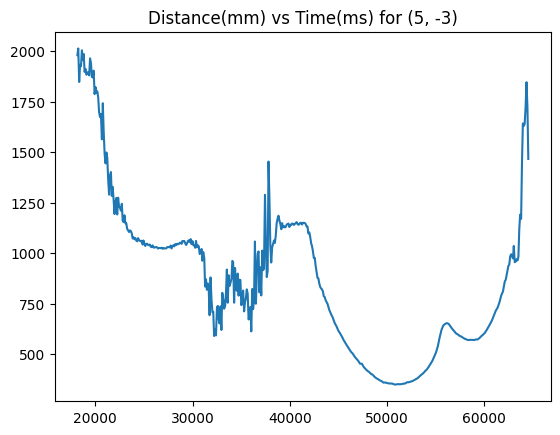

In [511]:
# for i in range(len(tof_data)):
#     tof_data[i] *= 2.2
#     tof_data[i] += 300
from matplotlib import pyplot as plt
plt.plot(tof_times, tof_data)
plt.title("Distance(mm) vs Time(ms) for (5, -3)")

In [554]:
import math
deg = np.linspace(0, 2*math.pi, len(tof_data))
rads = []
for i in imu_data:
    rads.append(i*math.pi/180)

Text(0.5, 1.0, 'Map (0, 0)')

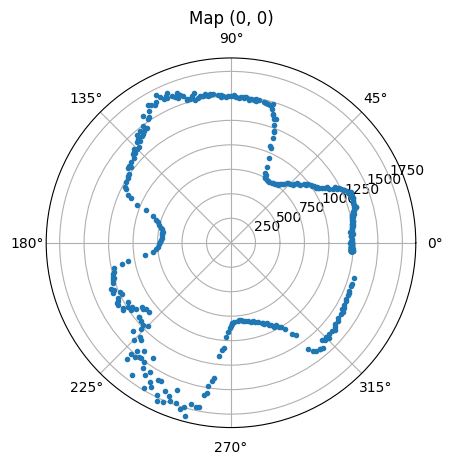

In [555]:
plt.polar(rads, tof_data, '.')
plt.title("Map (0, 0)")

In [ ]:
new_kf = []
for i in range(len(kf_data)):
    new_kf.append(kf_data[i] * -2.3)

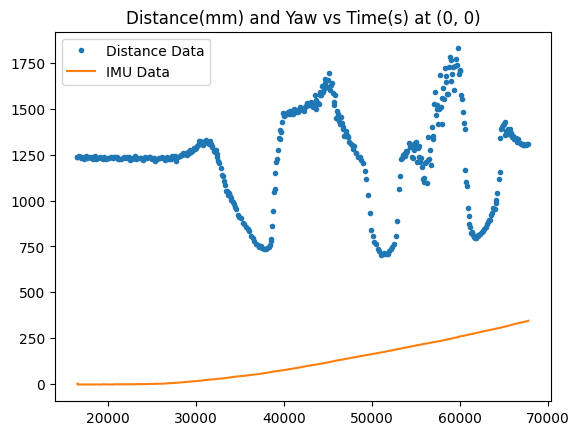

In [553]:
plt.plot(tof_times, tof_data, '.', label = 'Distance Data')
plt.plot(tof_times, imu_data, label = 'IMU Data')
plt.title("Distance(mm) and Yaw vs Time(s) at (0, 0)")
plt.legend()

In [ ]:
# speed_data = save_speed[50:]
# for i in range(4):
#     speed_data[i] = 0
for i in range(15):
    speed_data[i] = 255
for i in range(15, len(speed_data)):
    speed_data[i] = -255

In [587]:
tof_data

[888,
 890,
 890,
 888,
 887,
 887,
 889,
 890,
 889,
 894,
 892,
 886,
 887,
 887,
 885,
 887,
 888,
 889,
 891,
 884,
 887,
 892,
 892,
 885,
 888,
 888,
 889,
 889,
 893,
 893,
 889,
 889,
 899,
 900,
 901,
 903,
 906,
 908,
 908,
 909,
 910,
 911,
 915,
 915,
 914,
 914,
 920,
 919,
 925,
 926,
 927,
 930,
 935,
 937,
 939,
 944,
 948,
 948,
 951,
 955,
 958,
 973,
 975,
 979,
 984,
 988,
 986,
 1000,
 999,
 999,
 1005,
 1011,
 1014,
 1010,
 1017,
 1022,
 1025,
 1028,
 1029,
 1033,
 1037,
 1034,
 1039,
 1033,
 1035,
 1026,
 1023,
 1021,
 1022,
 1015,
 1014,
 1005,
 993,
 973,
 959,
 932,
 908,
 896,
 880,
 876,
 862,
 849,
 850,
 839,
 827,
 820,
 818,
 818,
 809,
 799,
 795,
 794,
 778,
 783,
 768,
 760,
 755,
 758,
 752,
 748,
 748,
 751,
 747,
 737,
 735,
 733,
 730,
 726,
 720,
 723,
 719,
 722,
 719,
 719,
 718,
 712,
 707,
 704,
 702,
 697,
 689,
 686,
 681,
 679,
 670,
 665,
 661,
 659,
 653,
 649,
 648,
 651,
 645,
 645,
 646,
 647,
 647,
 649,
 646,
 655,
 652,
 653,
 658,

In [ ]:
# for i in range(len(speed_data)):
#     speed_data[i] *= 1.5
from matplotlib import pyplot as plt
plt.plot(shifted_times, speed_data, '.')
plt.title("PWM vs Time(ms)")

In [ ]:
dydx = []
dt = []
# tof_data = save_tof
# tof_times = save_times
# scaled_times = [(t - tof_times[0])/1000.0 for t in tof_times]
# min_time = min(scaled_times)
# shifted_times = [t - min_time for t in scaled_times]

# dydx = np.diff(tof_data) / np.diff(shifted_times)
# dt = (np.array(shifted_times)[:-1] + np.array(shifted_times)[1:]) / 2

for i in range(len(tof_times)-1):
    temp = (tof_data[i+1]-tof_data[i])/(tof_times[i+1]-tof_times[i])
    #if(abs(temp) < 4000):
    dydx.append(temp)
print(dydx)
# print(dt)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(tof_times[:-1], dydx)
plt.title("Velocity(mm/s) vs Time(s)")

In [ ]:
# Find sampling rate
diffs = np.diff(tof_times)
print(sum(diffs)/len(diffs))

In [ ]:
import pickle
with open('times_kf2.pickle', 'wb') as f:
    pickle.dump(shifted_times, f, pickle.HIGHEST_PROTOCOL)
with open('tof_kf2.pickle', 'wb') as f:
    pickle.dump(tof_data, f, pickle.HIGHEST_PROTOCOL)
with open('speed_kf2.pickle', 'wb') as f:
    pickle.dump(speed_data, f, pickle.HIGHEST_PROTOCOL)
with open('velocity_kf2.pickle', 'wb') as f:
    pickle.dump(dydx, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
import sys
!{sys.executable} -m pip install scipy

In [ ]:
import scipy
import statistics
tof_data = save_tof
speed_data = save_sspeed
avg_data = []
avg_speed = []
for i in range(len(tof_data)-5):
    avg_data.append(statistics.mean(tof_data[i:i+5]))
    avg_speed.append(statistics.mean(speed_data[i:i+5]))

## Lab 7 - Kalman Filter

In [ ]:
drag = 0.000555
mass = 0.00326

A = np.array([[0, 1], 
              [0, -1*drag/mass]])
B = np.array([[0, 1/mass]])
C = np.array([[-1, 0]])

# Discretize A and B
delta_t = 0.093
Ad = np.eye(2) + delta_t * A  #n is the dimension of your state space 
Bd = delta_t * B

x = np.array([[-tof_data[0]],[0]])

# Noise covariance matrices
sigma_1 = 32.79
sigma_2 = 32.79
# sigma_3 = 20
# sigma_1 = 100
# sigma_2 = 100
sigma_3 = 10
sig_u=np.array([[sigma_1**2,0],[0,sigma_2**2]]) #We assume uncorrelated noise, and therefore a diagonal matrix works.
sig_z=np.array([[sigma_3**2]])

In [ ]:
# Kalman Filter
def kf(mu,sigma,u,y):
    
    mu_p = Ad.dot(mu) + np.dot(u,Bd) 
    sigma_p = Ad.dot(np.dot(sigma, Ad.transpose()) + sig_u)#sigma.dot(Ad.transpose())) + Sigma_u
    
    sigma_m = C.dot(sigma_p.dot(C.transpose())) + sig_z
    kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))

    y_m = y-C.dot(mu_p)
    mu = mu_p + kkf_gain.dot(y_m)    
    sigma=(np.eye(2)-kkf_gain.dot(C)).dot(sigma_p)

    return mu,sigma

In [ ]:
# Run code
kf_state = []

# Initial state uncertainty 
sig = np.array([[5**2,0],[0,5**2]])

# Initial state
x = np.array([[-tof_data[0]],[0]])

for u, d in zip(speed_data, tof_data):
    arr1 = np.array([[u/120]])
    arr2 = np.array([[d]])
    x, sig = kf(x, sig, [[u/120]], [[d]])
    kf_state.append(x[:,0])

In [ ]:
kf_save = kf_state

In [ ]:
kf_plot = []
for i in kf_state:
    kf_plot.append(-1*i[0])

In [ ]:
plt.plot(tof_times, tof_data, '.', label = 'Raw sensor data')
plt.plot(tof_times, kf_plot, label = 'Kalman filtered sensor data')
plt.title("Position(mm) vs Time(s)")
plt.legend()

## Lab 9 - Mapping

Convert from polar to cartesian coordinates, then offset by the coordinate there the robot took the readings. 

In [ ]:
import pickle
with open('map00_times.pickle', 'rb') as f:
    tof_times = pickle.load(f)
with open('map00_tof.pickle', 'rb') as f:
    tof_data = pickle.load(f)

In [ ]:
plt.polar(deg, tof_data, '.')
plt.title("Map (0,0)")

In [ ]:
import math
deg = np.linspace(0, 2*math.pi, len(tof_data))

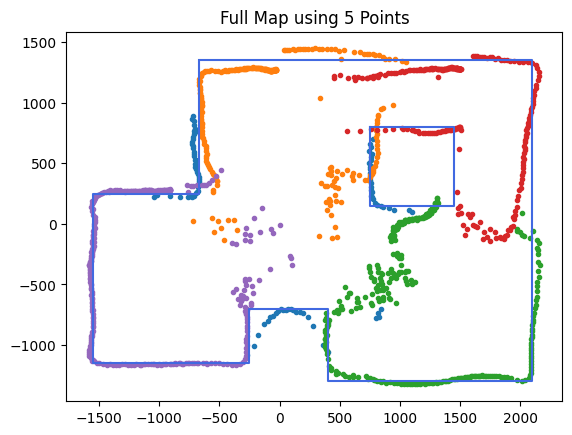

In [629]:
files = ['2map00_times.pickle', '2map00_tof.pickle', '2map00_imu.pickle', '2map03_times.pickle', '2map03_tof.pickle', '2map03_imu.pickle', '2map5-3_times.pickle', '2map5-3_tof.pickle', '2map5-3_imu.pickle', '2map53_times.pickle', '2map53_tof.pickle', '2map53_imu.pickle', '2map-3-2_times.pickle', '2map-3-2_tof.pickle', '2map-3-2_imu.pickle'] 
offsets = [(0,0),(0,3),(5,-3),(5,3),(-3,-2)]
rotation = [10, -70, 15, 35, -10]
for j in range(5):
    x1 = []
    y1 = []
    with open(files[j*3], 'rb') as f:
        tof_times = pickle.load(f)
    with open(files[j*3+1], 'rb') as f:
        tof_data = pickle.load(f)
    with open(files[j*3+2], 'rb') as f:
        imu_data = pickle.load(f) 
    rads = []
    for i in imu_data:
        rads.append((i+rotation[j])*math.pi/180)
    for i in range(len(rads)):
        if(tof_data[i] < 1150):
            x1.append(-tof_data[i]*math.sin(rads[i])+offsets[j][0]*304.8)
            y1.append(tof_data[i]*math.cos(rads[i])+offsets[j][1]*304.8)
    plt.plot(x1, y1, '.')
    plt.title("Full Map using 5 Points")
    
linex_wall = [-650, 2100, 2100, 400, 400, -250, -250, -1550, -1550, -670, -670]
liney_wall = [1350, 1350, -1300, -1300, -700, -700, -1150, -1150, 250, 250, 1350]

linex_box = [750, 1450, 1450, 750, 750]
liney_box = [800, 800, 150, 150, 800]

plt.plot(linex_wall, liney_wall, color = "royalblue")
plt.plot(linex_box, liney_box, color = "royalblue")

# real_linex_wall = [-1676, -1676, 1981, 1981, -762, -762, -1676]
# real_liney_wall = [152, -1371, -1371, 1371, 1371, 152, 152]

# real_linex_box1 = [762, 1371, 1371, 762, 762]
# real_liney_box1 = [-152, -152, 457, 457, -152]

# real_linex_box2 = [-152, -152, 152, 152, -152]
# real_liney_box2 = [-1371, -762, -762, -1371, -1371]

# plt.plot(real_linex_wall, real_liney_wall)
# plt.plot(real_linex_box1, real_liney_box1)
# plt.plot(real_linex_box2, real_liney_box2)

plt.show()

In [ ]:
plt.plot(x1, y1, '.')